# <span style="color:blue">EVAC Workshop 6: Competitive Coevolution</span>

**Module leader**

Simon O'Keefe: simon.okeefe@york.ac.uk

**Graduate Teaching Assistants**

Danny Roberts: danny.roberts@york.ac.uk

Tianda Sun: tianda.sun@york.ac.uk

## <span style="color:#0073e6">Learning objectives</span>

- To implement a simple competitive coevolutionary algorithm using DEAP
- To understand how the populations interact and the impact of changing parameters in each population
- Implement a common version of fitness sharing (diversity measure)

# <span style="color:blue">Practical Instructions</span>

This task takes a toy game to explore competitive evolution in a simplistic domain. The game is called the Matching Game and is a coevolutionary version of the max-ones game.

In this simple immune system-inspired game, there are two populations: parasites and hosts. Each population is represented by a bit-string. Parasites are rewarded for the number of their binary genes that match the corresponding binary genes of hosts, but hosts are rewarded for the number of genes
 that mismatch with the parasites. Games of this type often result in coevolutionary cycling, because hosts chase parasites through solution space.

**Fitness function:** Not all genes are always involved in this matching game. For parasites with many 1-alleles, the matching game tends to involve only those genes at which the parasite possesses 1-alleles. For parasites with many 0-alleles, the game tends to involve only those genes at which the parasite possesses 0-alleles. Whether 1-allele genes or 0-allele genes are involved is determined probabilistically. The probability, p, of a game involving matching 1-alleles increases with the total number of 1-alleles, x, that the parasite has such that:

$p = \frac{1}{2} \{ 1+\tanh(\frac{x-50}{7}) \}$

Otherwise the game matches based on only 0-alleles for that parasite and its host opponents.

Once the game has been decided, the fitness of the host is the number of genes that it mismatches for each individual, and the fitness of the parasite is the number of genes that match for each individual.

**If you want to start with a simpler version of the problem, you can implement the game with a simple evaluation function based simply on the number of genes matched (for the parasite) or unmatched (for the host), and then move on to this more complicated version.**

If you want to read more about a coevolutionary algorithm implementing this game, then you can read the paper:

> J. Cartlidge and S. Bullock, "Combating Coevolutionary Disengagement by Reducing Parasite Virulence," in Evolutionary Computation, vol. 12, no. 2, pp. 193-222, June 2004, doi: 10.1162/106365604773955148.

A copy is available on the VLE as matchingGame.pdf.

# <span style="color:blue">Exercise 1: Implement the coevolutionary problem</span>

Your task is to implement this game in DEAP. DEAP does not implement parasitic coevolution directly. However, parasitic evolution is simply two evolutionary algorithms running simultaneously, with the fitness of each population linked. So you can implement this using your current knowledge of DEAP. Implement the problem and try to understand the results.

**Implementation Details**

I suggest using the max-ones code you developed in the first practical as a starting point.
- Use two distinct populations (species) of size 50 each (hosts / parasites)
- Individuals in each population consist of binary strings containing 100 bits, initialised at random at generation 0.
- In each generation, members of the host population are selected to play a set of pair-wise contests against a random sample of 5 opponents from the parasite population.
- Each individual has a small probability of a bit-flip mutation with a probability per gene of 0.05 (indpb=0.05) for each population
- Use tournament selection with size 6
- Run for 150 generations to start with
- **Unlike standard evolution, you should not check to see if an individual has been modified (e.g. remove ‘invalid_ind’ and ‘del mutant.fitness.values’) before assessing their fitness, because relative fitness can change even if they have not been modified. Thus, you always need to reassess fitness.**

**Things to do:**
- To explore the coevolution of the hosts and parasites, plot the average number of 1s in each generation, for each population alongside each other on a graph.
- Try giving a high mutation rate (e.g. indpb=0.1) to the parasite, and lower to the host (e.g. indpb=0.01). How does this change the coevolutionary dynamic?
- Now reverse those mutation rates, so that the host has a mutational advantage. How does this change the coevolutionary dynamic?

In [120]:
POPSIZE = 50
NGEN, MUT_PROB = (
    150,
    0.5,
)
NUM_OPPONENTS = 5

In [121]:
import random
import matplotlib.pyplot as plt
from deap import base, creator, tools
import numpy as np
from IPython import display

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register(
    "individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=100
)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


def count_same(left, right):
    return sum([g_left == g_right for (g_left, g_right) in zip(left, right)])


def count_different(left, right):
    return sum([g_left != g_right for (g_left, g_right) in zip(left, right)])


def eval_parasite(ind):
    opponents = toolbox.select(popHost, NUM_OPPONENTS)
    fitness = np.mean([count_same(ind, opponent) for opponent in opponents])
    return (fitness,)


def eval_host(ind):
    opponents = toolbox.select(popParasite, NUM_OPPONENTS)
    fitness = np.mean([count_different(ind, opponent) for opponent in opponents])
    return (fitness,)


toolbox.register("select", tools.selTournament, tournsize=6)

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutateLow", tools.mutFlipBit, indpb=0.05)
toolbox.register("mutateHigh", tools.mutFlipBit, indpb=0.1)
toolbox.register("evalHost", eval_host)
toolbox.register("evalParasite", eval_parasite)


popHost = toolbox.population(n=50)
popParasite = toolbox.population(n=50)

stats = tools.Statistics(key=lambda ind: ind)
stats.register("avg", lambda pop: np.mean([ind.fitness.values for ind in pop]))
stats.register("std", lambda pop: np.std([ind.fitness.values for ind in pop]))
stats.register("min", lambda pop: np.min([ind.fitness.values for ind in pop]))
stats.register("max", lambda pop: np.max([ind.fitness.values for ind in pop]))
stats.register(
    "numOnes", lambda pop: np.mean([sum(x == 1 for x in ind) for ind in pop])
)

fitnesses_host = [toolbox.evalHost(ind) for ind in popHost]
fitnesses_parasite = [toolbox.evalParasite(ind) for ind in popParasite]

for ind, fit in zip(popHost, fitnesses_host):
    ind.fitness.values = fit

for ind, fit in zip(popParasite, fitnesses_parasite):
    ind.fitness.values = fit


logbook_host = tools.Logbook()
record_host = stats.compile(popHost)
logbook_host.record(gen=0, **record_host)

logbook_parasite = tools.Logbook()
record_parasite = stats.compile(popParasite)
logbook_parasite.record(gen=0, **record_parasite)

In [122]:
for g in range(NGEN):
    print("-- Generation %i --" % g)

    offspring_host = toolbox.select(popHost, len(popHost))
    offspring_host = list(map(toolbox.clone, offspring_host))
    offspring_parasite = toolbox.select(popParasite, len(popParasite))
    offspring_parasite = list(map(toolbox.clone, offspring_parasite))

    for child1, child2 in zip(offspring_host[::2], offspring_host[1::2]):
        toolbox.mate(child1, child2)

    for child1, child2 in zip(offspring_parasite[::2], offspring_parasite[1::2]):
        toolbox.mate(child1, child2)

    for mutant in offspring_parasite:
        if random.random() < MUT_PROB:
            toolbox.mutateLow(mutant)
    for mutant in offspring_host:
        if random.random() < MUT_PROB:
            toolbox.mutateLow(mutant)

    popHost[:] = offspring_host
    popParasite[:] = offspring_parasite

    fitnesses_host = [toolbox.evalHost(ind) for ind in popHost]
    fitnesses_parasite = [toolbox.evalParasite(ind) for ind in popParasite]

    for ind, fit in zip(popHost, fitnesses_host):
        ind.fitness.values = fit

    for ind, fit in zip(popParasite, fitnesses_parasite):
        ind.fitness.values = fit

    record = stats.compile(popParasite)
    logbook_parasite.record(gen=g, **record)

    record = stats.compile(popHost)
    logbook_host.record(gen=g, **record)

    # gen = [g] * POPSIZE
    # host = [sum(x) for x in popHost]
    # parasite = [sum(x) for x in popParasite]
    # plt.scatter(gen, host, color="red", s=15, alpha=0.05)
    # plt.scatter(gen, parasite, color="blue", s=15, alpha=0.05)
    # display.display(plt.gcf())
    # display.clear_output(wait=True)
    # sleep(0.5)

-- Generation 0 --
-- Generation 1 --
-- Generation 2 --
-- Generation 3 --
-- Generation 4 --
-- Generation 5 --
-- Generation 6 --
-- Generation 7 --
-- Generation 8 --
-- Generation 9 --
-- Generation 10 --
-- Generation 11 --
-- Generation 12 --
-- Generation 13 --
-- Generation 14 --
-- Generation 15 --
-- Generation 16 --
-- Generation 17 --
-- Generation 18 --
-- Generation 19 --
-- Generation 20 --
-- Generation 21 --
-- Generation 22 --
-- Generation 23 --
-- Generation 24 --
-- Generation 25 --
-- Generation 26 --
-- Generation 27 --
-- Generation 28 --
-- Generation 29 --
-- Generation 30 --
-- Generation 31 --
-- Generation 32 --
-- Generation 33 --
-- Generation 34 --
-- Generation 35 --
-- Generation 36 --
-- Generation 37 --
-- Generation 38 --
-- Generation 39 --
-- Generation 40 --
-- Generation 41 --
-- Generation 42 --
-- Generation 43 --
-- Generation 44 --
-- Generation 45 --
-- Generation 46 --
-- Generation 47 --
-- Generation 48 --
-- Generation 49 --
-- Generat

In [123]:
bestHost = tools.selBest(popHost, 1)[0]
bestParasite = tools.selBest(popParasite, 1)[0]
print(bestHost, "\n", bestParasite)

[0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1] 
 [1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1]


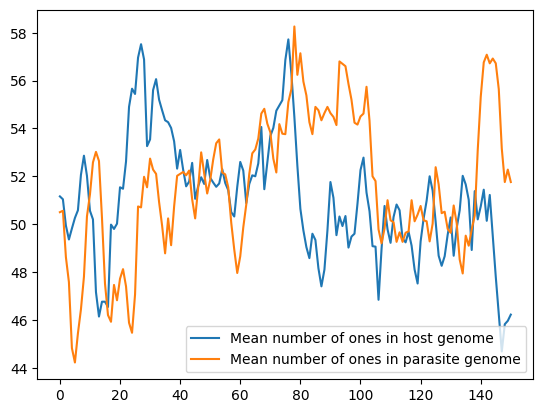

In [124]:
plt.plot(logbook_host.select("numOnes"), label="Mean number of ones in host genome")
plt.plot(
    logbook_parasite.select("numOnes"), label="Mean number of ones in parasite genome"
)
plt.legend()

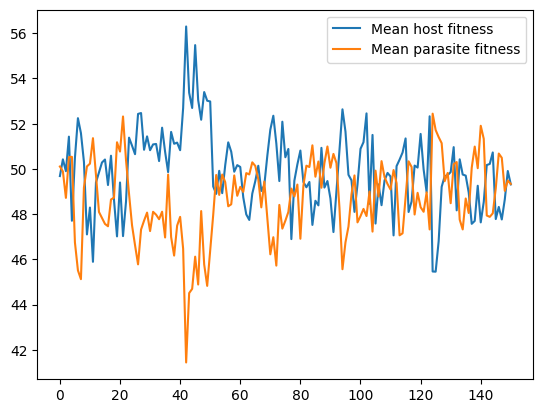

In [125]:
plt.plot(logbook_host.select("avg"), label="Mean host fitness")
plt.plot(logbook_parasite.select("avg"), label="Mean parasite fitness")
plt.legend()

## <span style="color:#0073e6">Live plotting</span>

As an optional extra, we could plot progress as the code runs. You do not have to do this, and could chose to save progress and plot later too. If you choose to do it, make sure that you import 'display' from IPython first.

At the end of each generation, within the loop, you can now plot the number of ones for each individual in each species using the code:

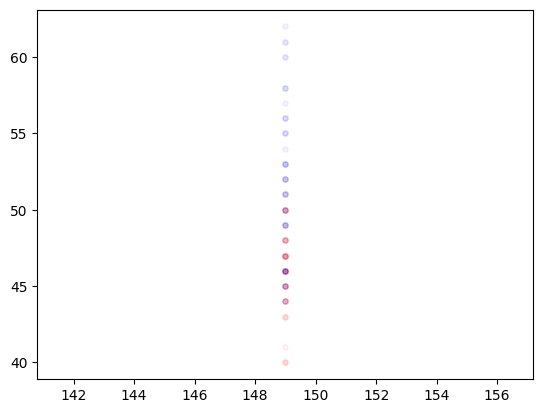

In [127]:
gen = [g] * POPSIZE
host = [sum(x) for x in popHost]
parasite = [sum(x) for x in popParasite]
plt.scatter(gen, host, color="red", s=15, alpha=0.05)
plt.scatter(gen, parasite, color="blue", s=15, alpha=0.05)
display.display(plt.gcf())
display.clear_output(wait=True)

Here, g is the current generation, POPSIZE is your population size (assuming equal population sizes for each species here), popHost is your host population and popParasite is your parasite population.

# <span style="color:blue">Exercise 2: Diversity measures and general strategies</span>

You can see that short-term strategies and cycling can occur a lot. This is simply a property of this problem. However, transitivity can be a real issue when it comes to other problems. As you have seen in the lectures, diversity measures can help with not only this, but with evolvability in general (and are particularly important for coevolution and multi-objective evolution).

Fitness sharing is a commonly used diversity method that we will implement. Although it will not make much difference for this problem, the intention here is to understand how to implement it for this problem.

Here is the pseudocode for how you could implement it here. To calculate the shared fitness for individual i:

```
alpha = 0.5
sigma = 5

res = 0
for each individual j in the population
    calculate the genotype distance from i to j
    if distance < sigma
        res += 1 – (distance/sigma)**alpha
fitness = (original_fitness / res),    
```

For our binary genomes, we can calculate the difference between genomes using the Hamming distance, which simply returns the number of positions where the two individuals differ. Below is a Python implementation of Hamming distance between two genotypes (s1 and s2):

In [128]:
def hamming(s1, s2):
    assert len(s1) == len(s2)
    return sum(c1 != c2 for c1, c2 in zip(s1, s2))

**Your task:** Implement fitness sharing for both populations.

In [129]:
ALPHA = 0.5
SIGMA = 5

In [130]:
def eval_parasite_shared(ind):
    opponents = toolbox.select(popHost, NUM_OPPONENTS)
    res = 0
    fitnesses = []
    for opponent in opponents:
        fitnesses.append(count_same(ind, opponent))
        distance = hamming(ind, opponent)
        if distance < SIGMA:
            res += 1 - (distance / SIGMA) ** ALPHA
    fitness = np.mean(fitnesses)
    if res != 0:
        fitness = fitness / res

    return (fitness,)


def eval_host_shared(ind):
    opponents = toolbox.select(popHost, NUM_OPPONENTS)
    res = 0
    fitnesses = []
    for opponent in opponents:
        fitnesses.append(count_different(ind, opponent))
        distance = hamming(ind, opponent)
        if distance < SIGMA:
            res += 1 - (distance / SIGMA) ** ALPHA

    fitness = np.mean(fitnesses)
    if res != 0:
        fitness = fitness / res

    return (fitness,)


toolbox.register("evalHost", eval_host_shared)
toolbox.register("evalParasite", eval_parasite_shared)

In [131]:
logbook_parasite.clear()
logbook_host.clear()
for g in range(NGEN):
    print("-- Generation %i --" % g)

    offspring_host = toolbox.select(popHost, len(popHost))
    offspring_host = list(map(toolbox.clone, offspring_host))
    offspring_parasite = toolbox.select(popParasite, len(popParasite))
    offspring_parasite = list(map(toolbox.clone, offspring_parasite))

    for child1, child2 in zip(offspring_host[::2], offspring_host[1::2]):
        toolbox.mate(child1, child2)

    for child1, child2 in zip(offspring_parasite[::2], offspring_parasite[1::2]):
        toolbox.mate(child1, child2)

    for mutant in offspring_parasite:
        if random.random() < MUT_PROB:
            toolbox.mutateLow(mutant)
    for mutant in offspring_host:
        if random.random() < MUT_PROB:
            toolbox.mutateLow(mutant)

    popHost[:] = offspring_host
    popParasite[:] = offspring_parasite

    fitnesses_host = [toolbox.evalHost(ind) for ind in popHost]
    fitnesses_parasite = [toolbox.evalParasite(ind) for ind in popParasite]

    for ind, fit in zip(popHost, fitnesses_host):
        ind.fitness.values = fit

    for ind, fit in zip(popParasite, fitnesses_parasite):
        ind.fitness.values = fit

    record = stats.compile(popParasite)
    logbook_parasite.record(gen=g, **record)

    record = stats.compile(popHost)
    logbook_host.record(gen=g, **record)

-- Generation 0 --
-- Generation 1 --
-- Generation 2 --
-- Generation 3 --
-- Generation 4 --
-- Generation 5 --
-- Generation 6 --
-- Generation 7 --
-- Generation 8 --
-- Generation 9 --
-- Generation 10 --
-- Generation 11 --
-- Generation 12 --
-- Generation 13 --
-- Generation 14 --
-- Generation 15 --
-- Generation 16 --
-- Generation 17 --
-- Generation 18 --
-- Generation 19 --
-- Generation 20 --
-- Generation 21 --
-- Generation 22 --
-- Generation 23 --
-- Generation 24 --
-- Generation 25 --
-- Generation 26 --
-- Generation 27 --
-- Generation 28 --
-- Generation 29 --
-- Generation 30 --
-- Generation 31 --
-- Generation 32 --
-- Generation 33 --
-- Generation 34 --
-- Generation 35 --
-- Generation 36 --
-- Generation 37 --
-- Generation 38 --
-- Generation 39 --
-- Generation 40 --
-- Generation 41 --
-- Generation 42 --
-- Generation 43 --
-- Generation 44 --
-- Generation 45 --
-- Generation 46 --
-- Generation 47 --
-- Generation 48 --
-- Generation 49 --
-- Generat

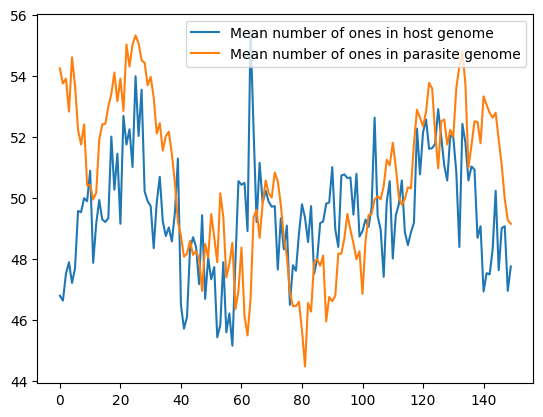

In [132]:
plt.plot(logbook_host.select("numOnes"), label="Mean number of ones in host genome")
plt.plot(
    logbook_parasite.select("numOnes"), label="Mean number of ones in parasite genome"
)
plt.legend()

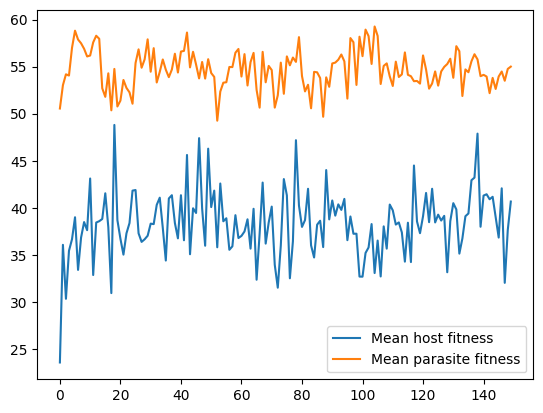

In [133]:
plt.plot(logbook_host.select("avg"), label="Mean host fitness")
plt.plot(logbook_parasite.select("avg"), label="Mean parasite fitness")
plt.legend()